In [1]:
%load_ext autoreload
%autoreload 2
import os
os.chdir('..')

In [2]:
import networkx as nx
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import numpy as np
import scipy.sparse
import matplotlib.pyplot as plt
from nn_homology import nn_graph

import persim # see persim.scikit-tda.org
from ripser import ripser # see ripser.scikit-tda.org

To generate the model used in this example, I ran:

`python main.py --arch_type lenet5_nmp --dataset cifar10 --prune_percent 90 --prune_iterations 2 --end_iter 50`

In [3]:
# Global-like variable definitions.
model_name = 'lenet5_nmp'
dataset_name = 'cifar10'
data_location = '../data' # location of training data (MNIST, FashionMNIST, CIFAR, etc.)
seed = 42 # prune percentage for LT network
model_loc0 = 'remote_saves/{}/{}/{}/0/model_lt_20.pth.tar'.format(model_name, dataset_name, seed) # location of saved, un-pruned model 
model_loc1 = 'remote_saves/{}/{}/{}/9/model_lt_20.pth.tar'.format(model_name, dataset_name, seed) # location of saved, pruned model (after 1 prune iteration)

## Unpruned Model Homology

In [4]:
# load the model.
model = torch.load(model_loc0)

In [5]:
param_info = [{'layer_type': 'Conv2d', 'kernel_size':(5,5), 'stride':1, 'padding': 0, 'name':'Conv1'},
                {'layer_type': 'Conv2d', 'kernel_size':(5,5), 'stride':1, 'padding':0, 'name':'Conv2'},
                {'layer_type':'Linear', 'name': 'Linear1'},
                {'layer_type':'Linear', 'name': 'Linear2'},
                {'layer_type':'Linear', 'name': 'Linear3'}]

# param_info = [{'layer_type': 'Conv2d', 'kernel_size':(3,3), 'stride':1, 'padding': 1, 'name':'Conv1'},
#                             {'layer_type': 'Conv2d', 'kernel_size':(3,3), 'stride':1, 'padding':1, 'name':'Conv2'},
#                             {'layer_type':'Conv2d', 'kernel_size':(4,4), 'stride':2, 'padding':1, 'name':'Conv3'},
#                             {'layer_type':'Linear', 'name': 'Linear1'},
#                             {'layer_type':'Linear', 'name': 'Linear2'},
#                            {'layer_type': 'Linear', 'name': 'Linear3'}]

In [6]:
NNG = nn_graph.NNGraph()
NNG.parameter_graph(model, param_info, (1,3,32,32), ignore_zeros=True)

In [7]:
# helper function for testing model, outputs accuracy
def test(model, test_loader, criterion):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1]  # get the index of the max log-probability
            correct += pred.eq(target.data.view_as(pred)).sum().item()
        test_loss /= len(test_loader.dataset)
        accuracy = 100. * correct / len(test_loader.dataset)
    return accuracy

In [8]:
# Test to make sure model works.
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
testdataset = datasets.CIFAR10(data_location, train=False, transform=transform)
test_loader = torch.utils.data.DataLoader(testdataset, batch_size=32, shuffle=False, num_workers=0,drop_last=True)
criterion = torch.nn.CrossEntropyLoss()
print('Accuracy: {}'.format(test(model, test_loader, criterion)))

Accuracy: 53.92


In [9]:
def sparse_min_row(csr_mat):
    ret = np.zeros(csr_mat.shape[0])
    ret[np.diff(csr_mat.indptr) != 0] = np.minimum.reduceat(csr_mat.data,csr_mat.indptr[:-1][np.diff(csr_mat.indptr)>0])
    return ret

In [10]:
# compute rips persistent homology (up to 1st dimension) over entire network 
# using (sparse) adjacency matrix as distance matrix.

def sparse_min_row(csr_mat):
    ret = np.zeros(csr_mat.shape[0])
    ret[np.diff(csr_mat.indptr) != 0] = np.minimum.reduceat(csr_mat.data,csr_mat.indptr[:-1][np.diff(csr_mat.indptr)>0])
    return ret

sps = nx.to_scipy_sparse_matrix(NNG.G)
mrs = sparse_min_row(sps)
sps.setdiag(mrs)


%time rips = ripser(sps, distance_matrix=True, maxdim=1)
rips

/home/schraterlab/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


CPU times: user 3.62 s, sys: 11.6 ms, total: 3.63 s
Wall time: 3.62 s


{'dgms': [array([[0.45414579, 0.4790369 ],
         [0.45414579, 0.4790369 ],
         [0.45414579, 0.4790369 ],
         ...,
         [0.64527535, 0.82055813],
         [0.64527535, 0.8251431 ],
         [0.41363642,        inf]]),
  array([[1.        ,        inf],
         [1.        ,        inf],
         [1.        ,        inf],
         ...,
         [0.55907553,        inf],
         [0.55907553,        inf],
         [0.54431885,        inf]])],
 'cocycles': [[], []],
 'num_edges': 434884,
 'dperm2all': <20038x20038 sparse matrix of type '<class 'numpy.float64'>'
 	with 889806 stored elements in Compressed Sparse Row format>,
 'idx_perm': array([    0,     1,     2, ..., 20035, 20036, 20037]),
 'r_cover': 0.0}

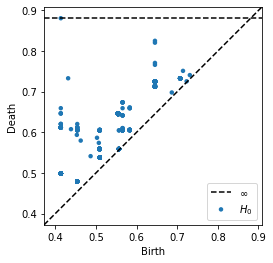

In [11]:
# plot persistence diagram in dimensions 0 and 1 (on same axes).
# points at infinity (homology groups) are plotted on the dotted 
# line which represents the point \infty.
persim.plot_diagrams(rips['dgms'][0])

## Pruned LT Homology

In [12]:
# load the LT model.
model_lt = torch.load(model_loc1)

In [13]:
# test this model's accuracy.
print('Accuracy: {}'.format(test(model_lt, test_loader, criterion)))

Accuracy: 42.55


In [14]:
NNGLT = nn_graph.NNGraph()
NNGLT.parameter_graph(model_lt, param_info, (1,3,32,32), ignore_zeros=True)

In [15]:
# compute rips persistent homology (up to 1st dimension) over entire network 
# using (sparse) adjacency matrix as distance matrix.
sps = nx.to_scipy_sparse_matrix(NNGLT.G)
mrs = sparse_min_row(sps)
sps.setdiag(mrs)
%time rips_lt = ripser(sps, distance_matrix=True, maxdim=1)
rips_lt

/home/schraterlab/anaconda3/lib/python3.8/site-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


CPU times: user 112 ms, sys: 3.88 ms, total: 116 ms
Wall time: 116 ms


{'dgms': [array([[0.38971883, 0.39451551],
         [0.37211487, 0.41403762],
         [0.36808315, 0.41433784],
         ...,
         [0.58740467,        inf],
         [0.86895448,        inf],
         [0.28295627,        inf]]),
  array([[1.        ,        inf],
         [1.        ,        inf],
         [1.        ,        inf],
         ...,
         [0.47797388,        inf],
         [0.44016632,        inf],
         [0.42168275,        inf]])],
 'cocycles': [[], []],
 'num_edges': 37270,
 'dperm2all': <17767x17767 sparse matrix of type '<class 'numpy.float64'>'
 	with 92307 stored elements in Compressed Sparse Row format>,
 'idx_perm': array([    0,     1,     2, ..., 17764, 17765, 17766]),
 'r_cover': 0.0}

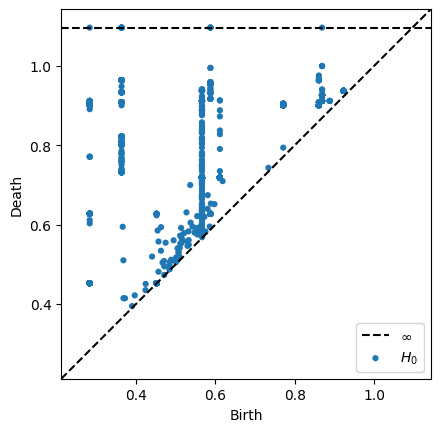

In [16]:
# plot persistence diagram in dimensions 0 and 1 (on same axes).
# points at infinity (homology groups) are plotted on the dotted 
# line which represents the point \infty.
persim.plot_diagrams(rips_lt['dgms'][0])

## Compare Networks

In [17]:
# compute the bottleneck distance between networks and plot the implicit matching. 
# bottleneck distance is defined as the distance between the farthest-apart matched points. 
# NOTE: the persim package ignores points at infinity, so this calculation still returns 
# a bounded result. Technically, the bottleneck distance between the two networks is \infty. 
# %time distance_bottleneck = persim.bottleneck(rips['dgms'][0], rips_lt['dgms'][0], matching=False)
# persim.bottleneck_matching(rips['dgms'][0], rips_lt['dgms'][0], matching, D, labels=['FC $H_0$', 'LT $H_0$'])
# print('Bottleneck Distance: {}'.format(distance_bottleneck))
# %time sliced = persim.sliced_wasserstein(rips['dgms'][0], rips_lt['dgms'][0])